```
         Copyright Rein Halbersma 2018-2020.
Distributed under the Boost Software License, Version 1.0.
   (See accompanying file LICENSE_1_0.txt or copy at
         http://www.boost.org/LICENSE_1_0.txt)
```

## 1. Extensions to setup heatmaps

In [1]:
from IPython.display import display, HTML

import gravon.package as pkg
from gravon.piece import Rank, rank_names
from gravon.stats import setup_placement
from gravon.plots import setup_heatmap1

db_setups = pkg.load_dataset('db_setups')
ranks = list(reversed(range(Rank._1, Rank._B))) + [ Rank._B, Rank._F ]

In [2]:
classic = db_setups.query('type == "classic"')

### a) Differences between 2003-2006 and 2013-2015

The Gravon database of Stratego games can be divided into two epochs: the period 2003-2006 and the period 2013-2015. Games in other periods are not available for download. We can plot the ratios of piece placement percentages for each piece and each square in the setup area. Some interesting patterns emerge: e.g. there were 3-4 times more setups with a corner marshal (on a1 or j1 for red) in the later period 2013-2015 than in the earlier period 2003-2006.

In [3]:
from gravon.plots import setup_heatmap2

classic_old = classic.query('period <= "2006-07"')
classic_new = classic.query('period >= "2013-10"')
mean_old = setup_placement(classic_old, 'mean')
mean_new = setup_placement(classic_new, 'mean')

The charts below compare Stratego piece placements from 72,700 and 29,976 setups, respectively.



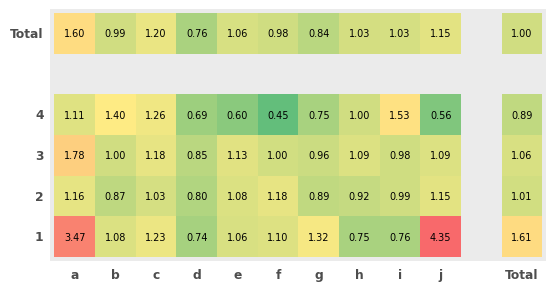

<ggplot: (8734376999897)>


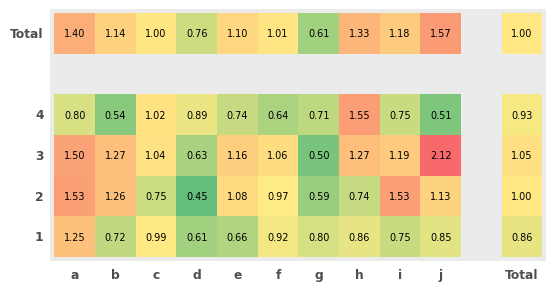

<ggplot: (8734376999798)>


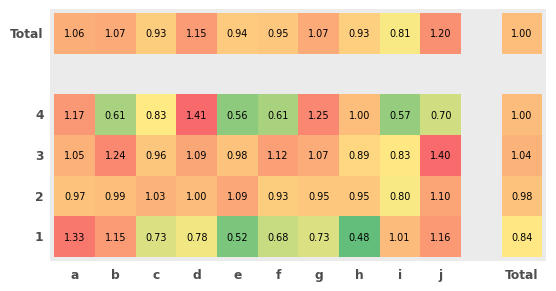

<ggplot: (8734375937166)>


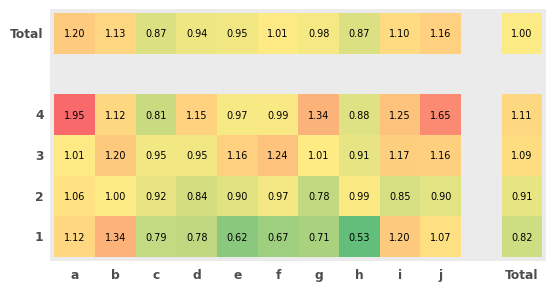

<ggplot: (8734375685500)>


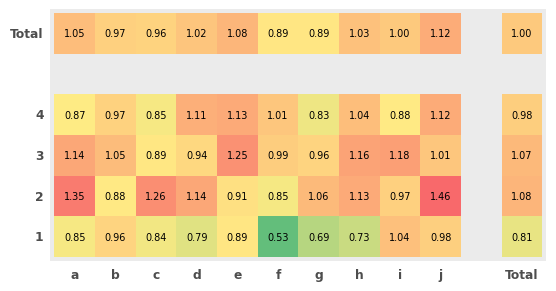

<ggplot: (8734375434490)>


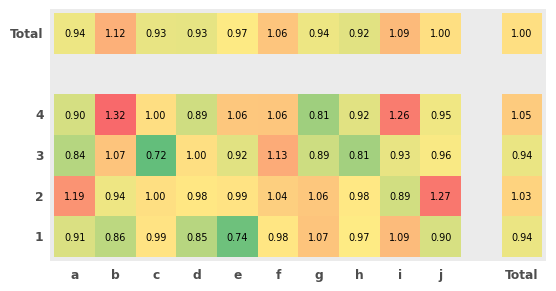

<ggplot: (8734375220468)>


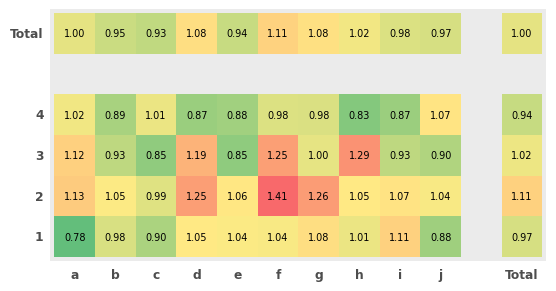

<ggplot: (8734375229877)>


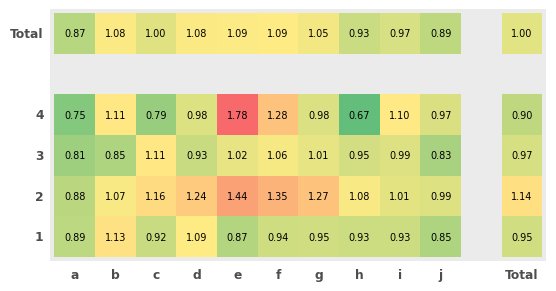

<ggplot: (8734377205381)>


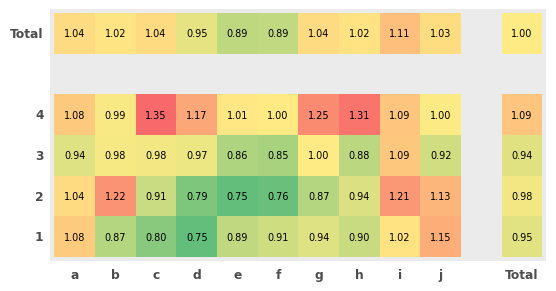

<ggplot: (8734374976341)>


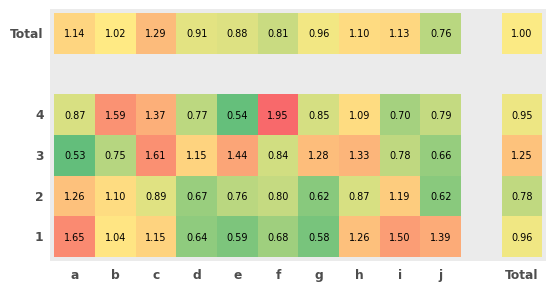

<ggplot: (8734376515642)>


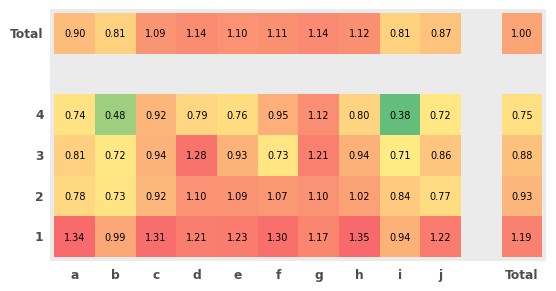

<ggplot: (8734375685380)>


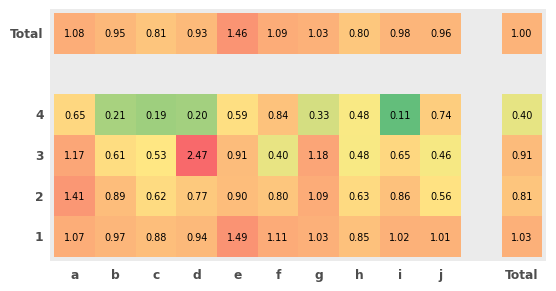

<ggplot: (8734373722173)>


In [4]:
print(f'The charts below compare Stratego piece placements from {classic_old.shape[0]:,} and {classic_new.shape[0]:,} setups, respectively.\n')
for r in ranks:
    display(HTML(f'<h3>Relative Changes in Classic Stratego {rank_names[r].capitalize()} Placement</h3>'))
    print(setup_heatmap2(mean_new[r], mean_old[r], format_string='{:.2f}', normalize=False))

### b) Mutual corner marshals

In [5]:
import gravon.archive as archive
import gravon.pattern as pattern

corner_marshal = (
    """
    ..........
    ..........
    ..........
    X.........
    """
)
df = pattern.match(classic, corner_marshal, mirrored=True)
mutual_corner_marshals = (df
    .groupby(['gid', 'filename'])
    .agg(**{'size': ('gid', 'count')})
    .query('size > 1')
    .reset_index()
    .filename
    .tolist()
)

In [6]:
print(f'In the following {len(mutual_corner_marshals):,} games both players had a corner marshal:')
print('\n'.join(mutual_corner_marshals))
archive.make_zip(mutual_corner_marshals, 'mutual_corner_marshals')

In the following 2 games both players had a corner marshal:
classic-2014.5-2437.xml
classic-2014.10-2531.xml


### c) Barrage Stratego

Barrage Stratego is a shorter version of the classic game with only 8 pieces each.

In [7]:
barrage = db_setups.query('type == "barrage"')
sum, mean = setup_placement(barrage, ['sum', 'mean'])
ranks = [ Rank._X, Rank._9, Rank._3, Rank._2, Rank._1, Rank._B, Rank._F ]

The charts below show Barrage Stratego piece placements from 6,264 setups.



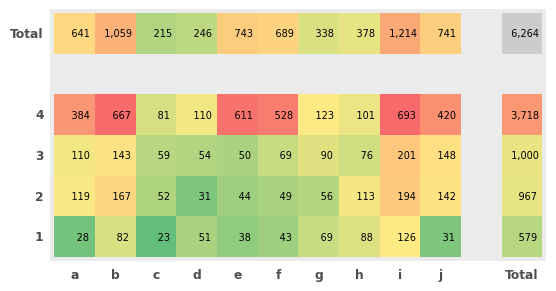

<ggplot: (8734373701828)>


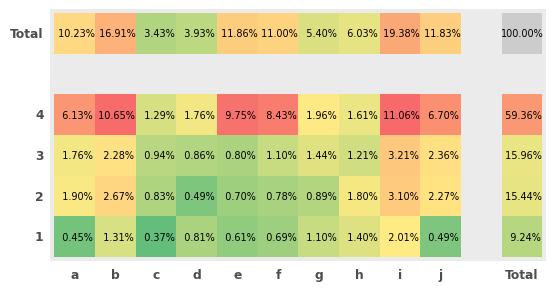

<ggplot: (8734373210492)>


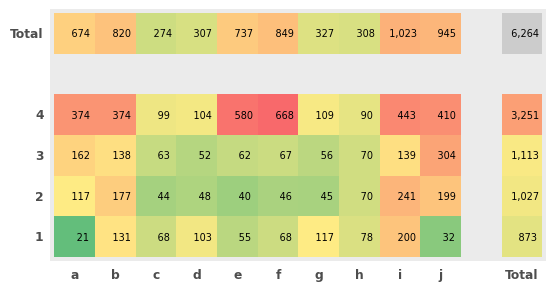

<ggplot: (8734373230731)>


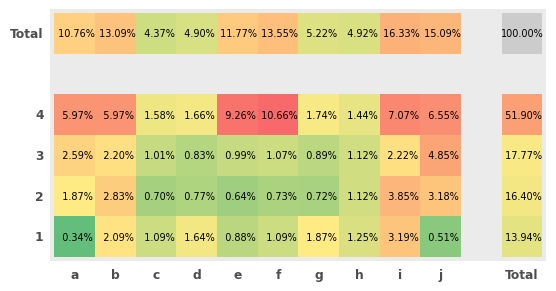

<ggplot: (8734372765489)>


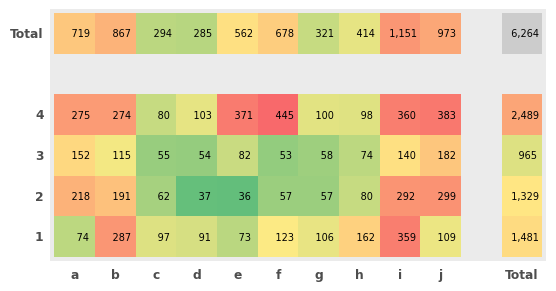

<ggplot: (8734373723962)>


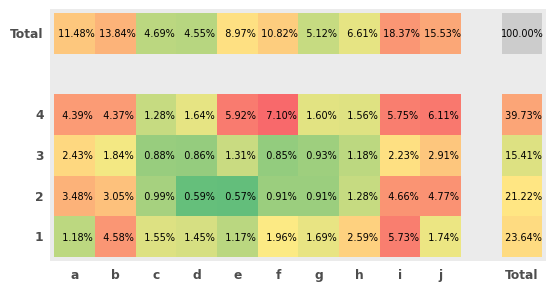

<ggplot: (8734372370201)>


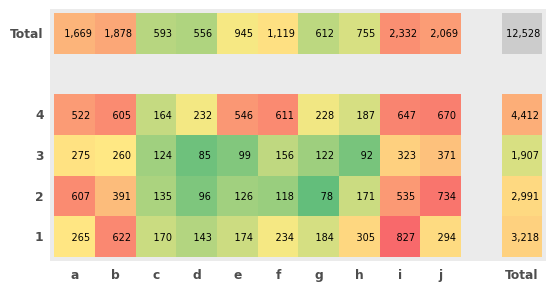

<ggplot: (8734372128997)>


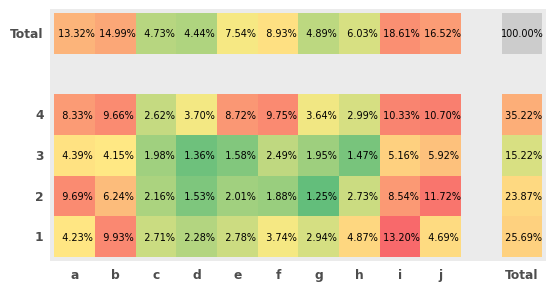

<ggplot: (8734371903516)>


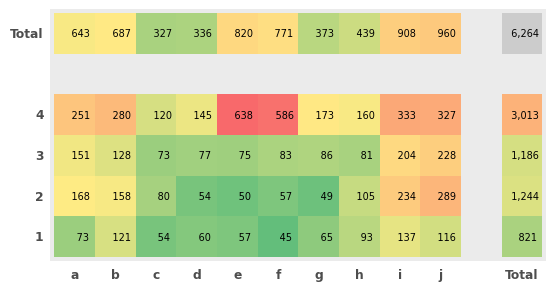

<ggplot: (8734371488738)>


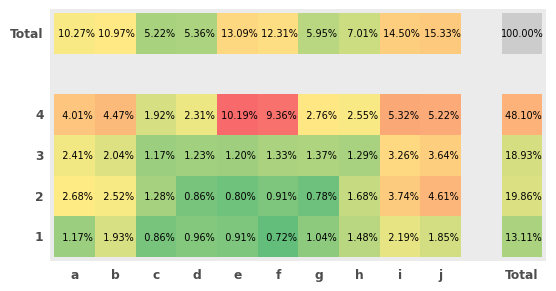

<ggplot: (8734371486031)>


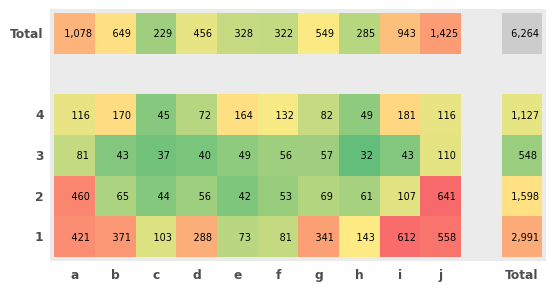

<ggplot: (8734373472738)>


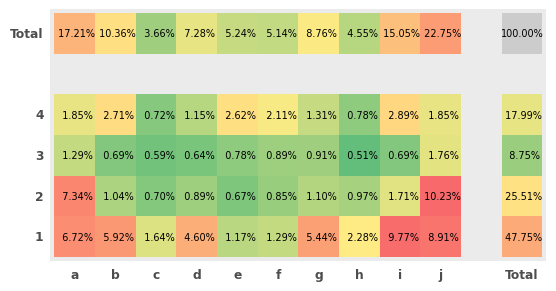

<ggplot: (8734377190416)>


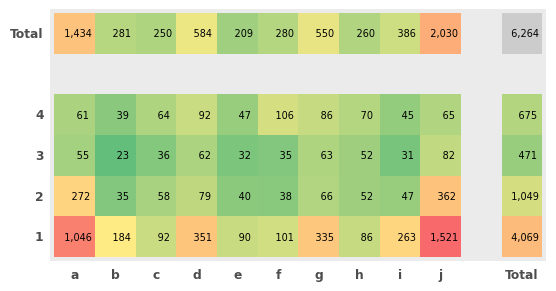

<ggplot: (8734375685596)>


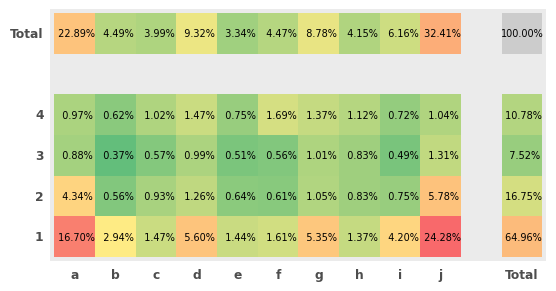

<ggplot: (8734375452739)>


In [8]:
print(f'The charts below show Barrage Stratego piece placements from {barrage.shape[0]:,} setups.\n')
for r in ranks:
    display(HTML(f'<h3>Barrage Stratego {rank_names[r].capitalize()} Placement</h3>'))
    print(setup_heatmap1( sum[r], format_string='{:>7,}',   normalize=False))
    print(setup_heatmap1(mean[r], format_string='{:>7.2%}', normalize=True ))

## 2. Extensions to front row flags

In [1]:
from IPython.display import display
import pandas as pd

import gravon.package as pkg
import gravon.archive as archive
import gravon.pattern as pattern
from gravon.stats import league_table

db_setups = pkg.load_dataset('db_setups')

In [3]:
front_row = {
    'Outside Wings': (
        """
        F.........
        ..........
        ..........
        ..........
        """
    ),
    'Inside Wings': (
        """
        .F........
        ..........
        ..........
        ..........
        """
    ),
    'Center Squares': (
        """
        ....F.....
        ..........
        ..........
        ..........
        """
    )
}

flag_fmt = {
    'flag columns': pd.CategoricalDtype(categories=front_row.keys())
}

score_fmt = {
    'Score': '{:.1%}'
}

### a) Mutual front row flags

In [4]:
classic = db_setups.query('type == "classic"')

df = (pd
    .concat([
        pattern.match(classic, flag_pattern, mirrored=True).assign(**{'flag columns': flag_columns})
        for flag_columns, flag_pattern in front_row.items()
    ])
    .rename(columns={'match_type': 'flag side'})
    .replace({'flag side': { 
        'identity': 'left', 
        'mirrored': 'right'
    }})
    .sort_values('gid')
    .astype(dtype=flag_fmt)
)

In [5]:
mutual_front_row_flags = (df
    .groupby(['gid', 'filename'])
    .agg(**{'size': ('gid', 'count')})
    .query('size > 1')
    .reset_index()
    .filename
    .tolist()
)

In [6]:
print(f'In the following {len(mutual_front_row_flags):,} games both players had a front row flag:')
print('\n'.join(mutual_front_row_flags))
archive.make_zip(mutual_front_row_flags, 'mutual_front_row_flags')

In the following 11 games both players had a front row flag:
classic.2003.10.19.4992.gsn
classic.2003.10.26.3363.gsn
classic-2005.11-1787.xml
classic-2005.11-6550.xml
classic-2006.0-313.xml
classic-2006.0-2034.xml
classic-2006.0-6787.xml
classic-2006.2-1642.xml
classic-2006.2-4060.xml
classic-2006.4-6137.xml
classic-2014.10-2664.xml
